## Chapter 7 Linear multiclass classification

# 7.8 Stochastic and mini-batch learning

As described in [Section 3.11](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_11_Minibatch.html), stochastic and mini-batch learning can drastically accelerate (particularly first order) local optimization algorithms.  Having completed our description of *linear* supervised learning techniques - that is regression, two-class, and multi-class classification - in this Section we look back and provide a new *online learning* perspective of the stochastic / mini-batch learning approaches.

In [ ]:
# append path for local library, data, and image import
import sys
sys.path.append('./chapter_7_library') 
sys.path.append('./chapter_7_images') 
sys.path.append('./chapter_7_datasets') 

# import section helper
import section_7_8_helpers

# dataset paths
dataset_path_1 = "chapter_7_datasets/MNIST_subset.pickle"

# image paths
image_path_1 = "chapter_7_images/ml_stochastic.png"
image_path_2 = "chapter_7_images/MNIST_examples.png"

# standard imports
import matplotlib.pyplot as plt
import IPython

# import autograd-wrapped numpy
import autograd.numpy as np

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 7.7.1 The stochastic gradient descent

In [Section 3.11](https://jermwatt.github.io/machine_learning_refined/notes/3_First_order_methods/3_11_Minibatch.html) we discussed the concept of stochastic - and more generally mini-batch - extensions of (particular first order) local optimization algorithms in order to accelerate the minimization of cost functions that consist of $P$ terms of the form 

\begin{equation}
g\left(\mathbf{w}\right) = \sum_{p=1}^P g_p\left(\mathbf{w}\right)
\end{equation}


where $g_1\,g_2,\,...,g_P$ are all functions of the same kind.  Looking backwards, in this Chapter as well as the two that proceeded it, absolutely *every cost function took this form*.  That is, every machine learning cost function for regression, two-class, and multi-class classification takes the general form above, and thus we can think about applying mini-batch optimization in tuning their parameters (this trend will continue as we move forward as well, e.g., when discussing the *autoencoder* in [Section 8.4](https://jermwatt.github.io/machine_learning_refined/notes/8_Linear_unsupervised_learning/8_4_Autoencoder.html)).  

For example, the Multiclass Softmax cost introduced in [Section 7.3.5](https://jermwatt.github.io/machine_learning_refined/notes/7_Linear_multiclass_classification/7_3_Perceptron.html)

\begin{equation}
g\left(\mathbf{w}_{0}^{\,},\,...,\mathbf{w}_{C-1}^{\,}\right) = \frac{1}{P}\sum_{p = 1}^P \left[\text{log}\left( \sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}}  \right) - \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}\right].
\end{equation}

takes this general form where

\begin{equation}
g_p\left(\mathbf{w}_{0}^{\,},\,...,\mathbf{w}_{C-1}^{\,}\right) =\text{log}\left( \sum_{c = 0}^{C-1}  e^{ \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_c^{\,}}  \right) - \mathring{\mathbf{x}}_{p}^T \overset{\,}{\mathbf{w}}_{y_p}^{\,}.
\end{equation}

In other words, *machine learning cost functions de-compose over their training data* where the summand $g_p$ measures the error of the cost on the $p^{th}$ training point.  As detailed in Section 3.11, the heart of the mini-batch idea is to minimize such a cost *sequentially* over small mini-batches of these summands, one mini-batch of summands at a time, as opposed to the standard local optimization step where minimize in the entire set of summands at once.  Now, since machine learning cost summands are inherently tied to training datapoints, in the context of machine learning we can think about mini-batch optimization *equivalently in terms of mini-batches of training data* as well.  Thus as opposed to a standard (also called full batch) local optimization technique that takes individual steps by sweeping through an *entire* set of training data *simultaneously*, the mini-batch approach has us take smaller steps sweeping through training data *sequentially* (with one complete sweep through the data being referred to as an *epoch* of mini-batch learning).  This machine learning / data driven interpretation is illustrated schematically in the Figure below.

In [5]:
IPython.display.HTML('''<img src="''' + image_path_1 + '''" width="100%" height="auto" alt=""/>''')

<figure>
<figcaption> <strong>Figure 1:</strong> <em> Schematic comparison of first iteration of (top panel) full batch and (bottom) stochastic gradient descent, through the lens of machine learning using (for the sake of simplicity) a small dataset of points.  In the full batch sweep we take a step in all points *simultaneously*, whereas (bottom panel) in the mini-batch approach we sweep through these points *sequentially*.  </em>
</figcaption>
</figure>

As with generic cost functions, mini-batch learning often greatly accelerates the minimization of machine learning cost functions (and thus the corresponding learning taking place).  This is particularly true when dealing with *very large datasets*, i.e., when $P$ is large.    With very large datasets the mini-batch approach can also help limit the amount of active memory consumed in storing data by loading in - at each step in a mini-batch epoch - *only the data included in the current mini-batch*.  The mini-batch approach can also be used (or interpreted) as a so-called *online learning* technique, wherein data actually *arises* in small mini-batches and is directly used to update the parameters of the associated model.  

#### <span style="color:#a50e3e;">Example 1. </span>  Comparing standard to minibatch gradient descent 

Recognizing handwritten digits is a popular multiclass classification problem commonly built into the software of mobile banking applications, as well as more traditional Automated Teller Machines, to give users e.g., the ability to automatically deposit paper checks. Here each class of data consists of (images of) several handwritten version of a single digit in the range $0-9$, giving a total of $10$ classes.  

In [8]:
IPython.display.HTML('''<img src="''' + image_path_2 + '''" width="45%" height="auto" alt="" class="center"/>''')

<figure>
<figcaption> <strong>Figure 2:</strong> <em> An illustration of various handwritten digits in a feature space. Handwritten digit recognition is a common multiclass classification problem. The goal here is to determine regions in the feature space where current (and future) instances of each type of handwritten digit are present.</em>
</figcaption>
</figure>

In the figure below we illustrate the acclerated convergence of mini-batch gradient descent over the standard method using $P = 50,000$ random training points from the MNIST dataset, a popoular collection of handwritten images like those described above, and the Multiclass Softmax cost.  In particular we show a comparison of the first $10$ steps / epochs of both methods, using a batch of size $200$ for the mini-batch size and the same steplength for both runs, where we see that the mini-batch run drastically accelerates minimization in terms of both the cost function (left panel) and number of misclassifications (right panel). 

In [2]:
# load data
import pickle
with open(dataset_path_1, "rb") as input_file:
    data = pickle.load(input_file)
    
x = data[0]
y = data[1] 

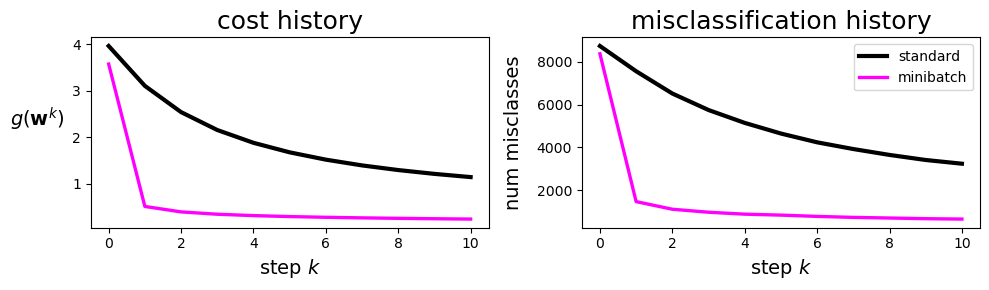

In [3]:
# import the v1 library
mylib0 = section_7_8_helpers.Setup(x, y)

# choose features
layer_sizes = [784,10]

# choose features
mylib0.choose_features(name = 'multilayer_perceptron',layer_sizes = layer_sizes,activation = 'linear')

# choose normalizer
mylib0.choose_normalizer(name = 'standard')

# choose cost
mylib0.choose_cost(name = 'multiclass_softmax')

# fit an optimization
alpha = 10**(-1)
mylib0.fit(max_its = 10,alpha_choice = alpha)
mylib0.fit(max_its = 10,alpha_choice = alpha,batch_size = 200,w_init = mylib0.w_init)

# show histories
labels = ['standard','minibatch']
mylib0.show_histories(labels = labels)